In [24]:
# 📦 Cell 1 – setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from itertools import cycle

warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': [15, 20],
    'font.family': 'sans-serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 16
})

print("Currency ETF analysis environment ready")


Currency ETF analysis environment ready


In [25]:
# 📂 Cell 2 – load data
file_path = "/content/Currency_ETF_2017-mid_june25.csv"    # adjust as needed
raw_df = pd.read_csv(file_path)

price_rows = raw_df.iloc[5:].copy()
price_rows = price_rows[price_rows['Start Date'].notna()]

ticker_row = raw_df.iloc[2]
etf_cols = {ticker_row[col].split()[0]: col
            for col in raw_df.columns
            if isinstance(ticker_row[col], str) and 'Equity' in ticker_row[col]}

print(f"Found {len(etf_cols)} ETFs")


Found 30 ETFs


In [26]:
# 🎨 Cell 3 – colour map
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ticker_colors = {tic: next(color_cycle) for tic in etf_cols}


In [27]:
# 🔧 Cell 4 – helper functions
def get_series(ticker: str):
    """Return DataFrame with Date, Price, CumReturn, CumLogReturn."""
    if ticker not in etf_cols:
        return None

    price_col = raw_df.columns[raw_df.columns.get_loc(etf_cols[ticker]) + 3]
    out = price_rows[['Start Date', price_col]].copy()
    out.columns = ['Date', 'Price']
    out['Price'] = pd.to_numeric(out['Price'], errors='coerce')
    out = out.dropna()
    out['Date'] = pd.to_datetime(out['Date'])
    if out.empty:
        return None

    base_price = out['Price'].iloc[0]
    out['CumReturn']    = (out['Price'] / base_price) * 100          # arithmetic index
    out['LogReturn']    = np.log(out['Price']).diff().fillna(0)      # daily log return
    out['CumLogReturn'] = out['LogReturn'].cumsum()                  # natural-log scale
    return out


def build_dataset():
    data = {tic: get_series(tic) for tic in etf_cols}
    data = {k: v for k, v in data.items() if v is not None}
    start = max(df['Date'].min() for df in data.values())
    print(f"Common start date: {start:%Y-%m-%d}")
    for k in data:
        data[k] = data[k][data[k]['Date'] >= start].copy()
    return data


In [28]:
# 📊 Cell 5 – process ETFs
etf_data = build_dataset()
print(f"Processed {len(etf_data)} tickers")

first_ticker = next(iter(etf_data))
etf_data[first_ticker].head()


Common start date: 2017-01-02
Processed 30 tickers


,Date,Price,CumReturn,LogReturn,CumLogReturn
5,2017-01-02,26.46,100.000000,0.000000,0.000000
6,2017-01-03,26.70,100.907029,0.009029,0.009029
7,2017-01-04,26.50,100.151172,-0.007519,0.001511
8,2017-01-05,26.22,99.092971,-0.010622,-0.009112
9,2017-01-06,26.41,99.811036,0.007220,-0.001891


In [29]:
# 🗂️ Cell 6 – category definitions (auto-filtered)
base_categories = {
    "Major Currencies": ["UUP", "UDN", "USDU", "FXE", "FXB", "FXY"],
    "Emerging Markets": ["CEW", "FXCH", "BZF", "HEEM", "HEWW", "HEZU"],
    "Hedged Currency ETFs": ["HEDJ", "HEFA", "HEWJ", "HEWW", "HEZU"],
    "Leveraged & Inverse": ["EUO", "ULE", "YCL", "YCS", "EUFX"]
}

categories = {name: [t for t in tickers if t in etf_data]
              for name, tickers in base_categories.items()}
categories = {name: tickers for name, tickers in categories.items() if tickers}
print("Categories prepared")


Categories prepared


In [30]:
# 🖼️ Cell 7 – plot helpers
def plot_group(ax_left, ax_right, group_name, tickers):
    for tic in tickers:
        df = etf_data[tic]
        ax_left.plot(df['Date'], df['CumReturn'],
                     label=tic, color=ticker_colors[tic])
        ax_right.plot(df['Date'], df['CumLogReturn'],
                      label=tic, color=ticker_colors[tic])

    ax_left.set_title(group_name)
    ax_left.set_ylabel("Cumulative Return (index = 100)")
    ax_right.set_ylabel("Cumulative Log Return")
    ax_left.legend()
    ax_right.legend()


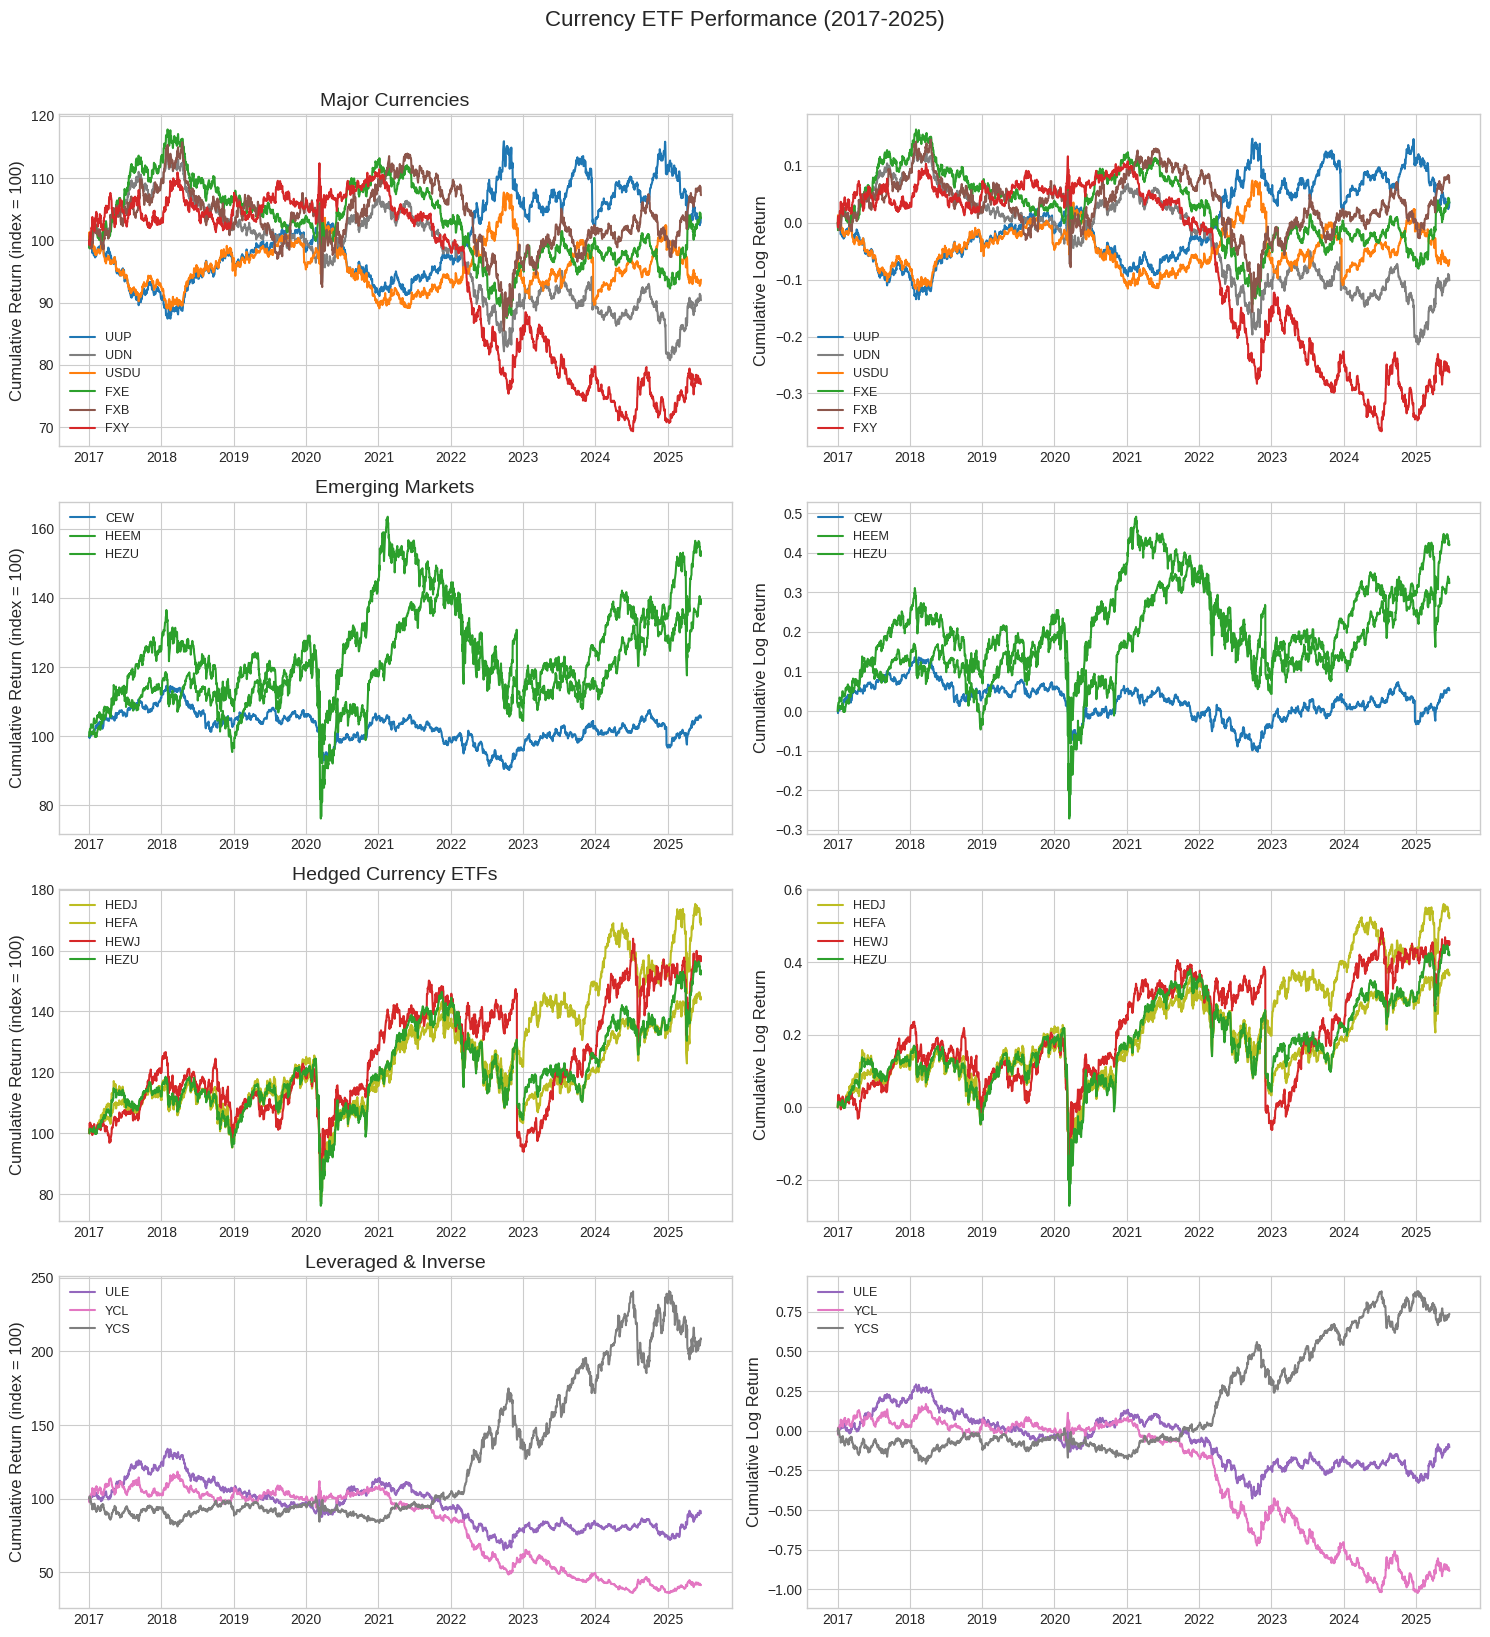

In [31]:
# 📈 Cell 8 – draw charts
n_groups = len(categories)
fig, axes = plt.subplots(n_groups, 2, figsize=(15, 4 * n_groups))

if n_groups == 1:                # keep indexing consistent
    axes = np.array([axes])

for idx, (name, tickers) in enumerate(categories.items()):
    plot_group(axes[idx, 0], axes[idx, 1], name, tickers)

fig.suptitle("Currency ETF Performance (2017-2025)", y=1.02)
plt.tight_layout()
plt.show()
